In [1]:
# univariate multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


Using TensorFlow backend.


In [1]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
 
# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]
 
# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

FileNotFoundError: [Errno 2] File b'household_power_consumption.txt' does not exist: b'household_power_consumption.txt'

In [ ]:
# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

In [2]:
# load the new file
dataset = read_csv('train.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date']).sort_values('Date')
dataset = dataset[['Sales','Store', 'DayOfWeek','Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday']]
dataset = pd.DataFrame(dataset[dataset['Store']==1])
dataset

c:\python3.6.7\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Sales,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,0,1,2,0,0,0,a,1
2013-01-02,5530,1,3,668,1,0,0,1
2013-01-03,4327,1,4,578,1,0,0,1
2013-01-04,4486,1,5,619,1,0,0,1
2013-01-05,4997,1,6,635,1,0,0,1
2013-01-06,0,1,7,0,0,0,0,1
2013-01-07,7176,1,1,785,1,1,0,1
2013-01-08,5580,1,2,654,1,1,0,1
2013-01-09,5471,1,3,626,1,1,0,1


In [3]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-59], data[-55:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    #print("split_data : ", train)
    return train, test

In [4]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [5]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [6]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    #print("original_data", data)
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [7]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    print("X_train Data : ",train_x[0:4])
    print("y_train Data : ",train_y[0:4])
    # define parameters
    verbose, epochs, batch_size = 0, 20, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [8]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    #print("forcast_data: ", len(data), data)
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    #print("input_x : ", input_x)
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [9]:

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    print("history : ", history)
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [10]:
#print(len(train_set.values))
train, test = dataset.values[1:-59], dataset.values[-55:-6]
# restructure into windows of weekly data
x = len(train)/7
n = len(train)/x
print(len(train), x, n)
y = len(test)/7
z = len(test)/y
print(len(test), y, z)
train = array(split(train, abs(len(train)/7)))
test = array(split(test, abs(len(test)/7)))

882 126.0 7.0
49 7.0 7.0


X_train Data :  [[[5530]
  [4327]
  [4486]
  [4997]
  [0]
  [7176]
  [5580]]

 [[4327]
  [4486]
  [4997]
  [0]
  [7176]
  [5580]
  [5471]]

 [[4486]
  [4997]
  [0]
  [7176]
  [5580]
  [5471]
  [4892]]

 [[4997]
  [0]
  [7176]
  [5580]
  [5471]
  [4892]
  [4881]]]
y_train Data :  [[5471 4892 4881 4952 0 4717 3900]
 [4892 4881 4952 0 4717 3900 4008]
 [4881 4952 0 4717 3900 4008 4044]
 [4952 0 4717 3900 4008 4044 4127]]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
history :  [array([[5530, 1, 3, 668, 1, 0, '0', 1],
       [4327, 1, 4, 578, 1, 0, '0', 1],
       [4486, 1, 5, 619, 1, 0, '0', 1],
       [4997, 1, 6, 635, 1, 0, '0', 1],
       [0, 1, 7, 0, 0, 0, '0', 1],
       [7176, 1, 1, 785, 1, 1, '0', 1],
       [5580, 1, 2, 654, 1, 1, '0', 1]], dtype=object), array([[5471, 1, 3, 626, 1, 1, '0', 1],
       [4892, 1, 4, 615, 1, 1, '0', 1],
       [4881, 1, 5, 592, 1, 1, '0', 1],
       [4952, 1, 6, 646, 1, 0, '0', 

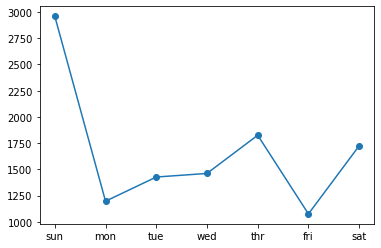

In [11]:
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()